In [1]:
import pandas as pd
import sys
import os
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from category_encoders import TargetEncoder
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, make_scorer
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath("../Sources"))
pd.set_option('display.max_columns', None) 

In [2]:
train = pd.read_csv('..\Datasets\Copy of churn-bigml-80.csv')
test = pd.read_csv('..\Datasets\Copy of churn-bigml-20.csv')

In [3]:
from preprocessing import preprocess_pipeline

In [4]:
X_train, y_train, X_test, y_test, feature_names = preprocess_pipeline(train, test, model='logreg')

In [5]:
f1_scorer = make_scorer(f1_score, average='macro')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = LogisticRegression(max_iter=1000, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scorer)

print("F1 scores on each fold:", scores)
print("Mean F1 score:", scores.mean())

F1 scores on each fold: [0.77083085 0.76271922 0.74861698 0.76607825 0.78700383]
Mean F1 score: 0.7670498270330265


In [6]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-4, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'max_iter': 1000,
        'random_state': 42
    }

    if params['penalty'] == 'l1' and params['solver'] not in ['liblinear', 'saga']:
        raise optuna.exceptions.TrialPruned()

    model = LogisticRegression(**params)
    score = cross_val_score(model, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial)
print("Best parameters:", study.best_params)

[I 2025-05-18 23:37:03,671] A new study created in memory with name: no-name-bf1c148e-9f44-44d6-9a65-0f02d2819661
[I 2025-05-18 23:37:06,301] Trial 0 finished with value: 0.7197333844452806 and parameters: {'C': 0.0011964844340666624, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7197333844452806.
[I 2025-05-18 23:37:10,093] Trial 1 finished with value: 0.766184171055054 and parameters: {'C': 4.887962625629306, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.766184171055054.
[I 2025-05-18 23:37:11,912] Trial 2 finished with value: 0.3333332619298296 and parameters: {'C': 0.0004849681133755488, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.766184171055054.
[I 2025-05-18 23:37:13,855] Trial 3 finished with value: 0.3333332619298296 and parameters: {'C': 0.00012756112742868535, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.766184171055054.
[I 2025-05-18 23:37:14,020] Trial 4 finished with val

Best trial:
FrozenTrial(number=15, state=1, values=[0.7686032864759663], datetime_start=datetime.datetime(2025, 5, 18, 23, 37, 21, 822408), datetime_complete=datetime.datetime(2025, 5, 18, 23, 37, 22, 303721), params={'C': 0.4666952604335618, 'penalty': 'l2', 'solver': 'saga'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=10.0, log=True, low=0.0001, step=None), 'penalty': CategoricalDistribution(choices=('l1', 'l2')), 'solver': CategoricalDistribution(choices=('liblinear', 'saga'))}, trial_id=15, value=None)
Best parameters: {'C': 0.4666952604335618, 'penalty': 'l2', 'solver': 'saga'}


Classification Report:

              precision    recall  f1-score   support

           0     0.9534    0.7517    0.8407       572
           1     0.3426    0.7789    0.4759        95

    accuracy                         0.7556       667
   macro avg     0.6480    0.7653    0.6583       667
weighted avg     0.8664    0.7556    0.7887       667



<Axes: >

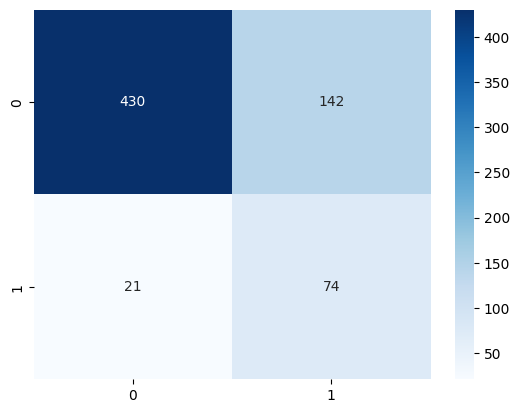

In [7]:
best_model = LogisticRegression(**study.best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

In [8]:
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df.head(10))

                   Feature  Coefficient
23               day_ratio    -2.478729
25             night_ratio     1.750514
5        Total day minutes     1.463890
7         Total day charge     1.457722
28        intl_calls_ratio    -0.994914
29            Total charge     0.986562
3          Voice mail plan    -0.951064
13      Total night charge    -0.915933
11     Total night minutes    -0.885143
17  Customer service calls     0.789559


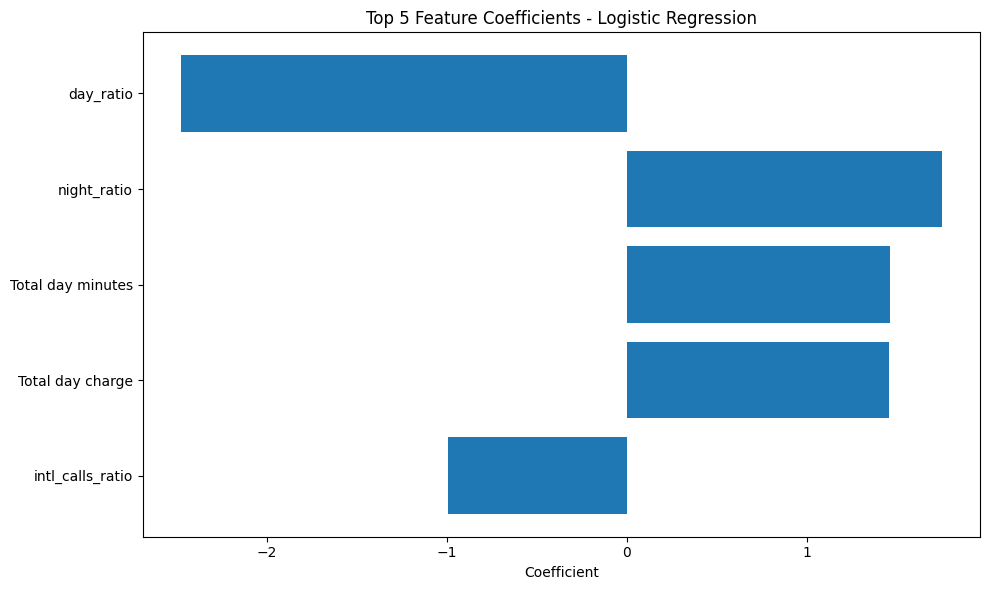

In [9]:
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][:5][::-1], coef_df['Coefficient'][:5][::-1])
plt.xlabel("Coefficient")
plt.title("Top 5 Feature Coefficients - Logistic Regression")
plt.tight_layout()
plt.show()